In [6]:
import numpy as np

In [22]:
def rbm_phi(s, a, b, W):
    c = np.dot(a, s)
    d = 1
    for i in range(len(b)):
        d *= 2 * np.cosh(b[i] + np.dot(W[i], s))
        

    return np.exp(c) * d


def rbm_phi_flat(s, a, b, W):
    W = np.reshape(W, (len(b), len(s)))
    return rbm_phi(s, a, b, W)

In [23]:
def o_der_a(s, a, b, W):
    return s

In [24]:
def o_der_b(s, a, b, W):
    return np.array([np.tanh(b[i] + np.dot(W[i], s)) for i in range(len(b))])

In [25]:
def o_der_W(s, a, b, W):
    return np.array([[s[k] * np.tanh(b[i] + np.dot(W[i], s)) for k in range(len(W[0]))] for i in range(len(W))])


In [26]:
# Let's text the derivative functions by comparing them to finite difference approximations.

def finite_diff(f, x, i, h):
    return (f(x + h * np.eye(len(x))[i]) - f(x - h * np.eye(len(x))[i])) / (2 * h)

def finite_diff_grad(f, x, h):
    return np.array([finite_diff(f, x, i, h) for i in range(len(x))])

def test_derivatives():
    a = np.array([0.1, 0.2])
    b = np.array([0.3, 0.4])
    W = np.array([[0.5, 0.6], [0.7, 0.8]])
    s = np.array([1, 0])


    print("RBM values:")
    print(rbm_phi(s, a, b, W))


    h = 1e-6
    print("Analytical derivatives:")
    print(o_der_a(s, a, b, W)*rbm_phi(s, a, b, W))
    print(o_der_b(s, a, b, W)*rbm_phi(s, a, b, W))
    print(o_der_W(s, a, b, W)*rbm_phi(s, a, b, W).flatten())

    print("Finite difference derivatives:")
    print(finite_diff_grad(lambda x: rbm_phi(s, x, b, W), a, h))
    print(finite_diff_grad(lambda x: rbm_phi(s, a, x, W), b, h))
    print(finite_diff_grad(lambda x: rbm_phi_flat(s, a, b, x), W.flatten(), h))



In [27]:
test_derivatives()

RBM values:
9.864910437871492
Analytical derivatives:
[9.86491044 0.        ]
[6.55066327 7.89685116]
[[6.55066327 0.        ]
 [7.89685116 0.        ]]
Finite difference derivatives:
[9.86491044 0.        ]
[6.55066327 7.89685115]
[6.55066327 0.         7.89685115 0.        ]


In [43]:
def rbm_phi_theta(s, theta):
    n = len(s)
    m = (len(theta) - n) // (n+1)
    a = theta[:n]
    b = theta[n:n+m]
    W = np.reshape(theta[n+m:], (m, n))
    return rbm_phi(s, a, b, W)

def o_der_theta(s, theta):
    n = len(s)
    m = (len(theta) - n) // (n+1)
    a = theta[:n]
    b = theta[n:n+m]
    W = np.reshape(theta[n+m:], (m, n))
    return np.concatenate([o_der_a(s, a, b, W), o_der_b(s, a, b, W), o_der_W(s, a, b, W).flatten()])




In [37]:
def create_random_state(N, M):
    phi = np.random.rand(N)
    a = np.random.rand(N)
    b = np.random.rand(M)
    W = np.random.rand(M, N)

    return phi, a, b, W



In [38]:
def loss(phi, theta, N):
    l = 0
    magnitude = np.sum([rbm_phi_theta(np.eye(N)[j], theta) for j in range(N)])
    for i in range(N):
        si = np.eye(N)[i]
        l += np.square(phi[i] - rbm_phi_theta(si, theta)/magnitude)
    return l/2

In [40]:
def diff_loss(phi, theta, N):
    magnitude = np.sum([rbm_phi_theta(np.eye(N)[j], theta) for j in range(N)])
    d = 0
    for i in range(N):
        si = np.eye(N)[i]
        derivativetimesphi = np.sum([rbm_phi_theta(np.eye(N)[j], theta)**2*o_der_theta(np.eye(N)[j], theta) for j in range(N)])
        d += (phi[i] - rbm_phi_theta(si, theta)/magnitude) * (o_der_theta(si, theta)*rbm_phi_theta(si, theta)/magnitude - rbm_phi_theta(si, theta)/magnitude**3 * derivativetimesphi)
    return d

In [49]:
def gradient_descent(s, theta, phi, learning_rate, max_iter):
    for i in range(max_iter):
        theta += learning_rate * diff_loss(phi, theta, len(s))
        print("Loss:", loss(phi, theta, len(s)))
    return theta

In [65]:
N, M = 3, 7

phi, random_a, random_b, random_W = create_random_state(N, M)
random_theta = np.concatenate([random_a, random_b, random_W.flatten()])
print(len(random_theta))
print("Initial loss:", loss(phi, random_theta, N))
print("Initial random theta:", random_theta)
print("Initial random phi:", phi)
print("Gradient descent:")
new_theta = gradient_descent(phi, random_theta, random_theta, 0.001, 1000)
print("Final loss:", loss(phi, new_theta, N))
print("Final theta:", new_theta)


31
Initial loss: 0.10169676944164624
Initial random theta: [0.89403338 0.56442927 0.90533169 0.53265747 0.06679585 0.73713874
 0.49655299 0.44098516 0.40522302 0.56223651 0.77698139 0.23880484
 0.10067321 0.05367712 0.49427081 0.27241659 0.20212603 0.74140228
 0.42583529 0.85816483 0.28031493 0.18898766 0.94600449 0.28624008
 0.49919348 0.08929416 0.61947824 0.17388744 0.46132215 0.85144936
 0.90947213]
Initial random phi: [0.71532654 0.67342555 0.28941385]
Gradient descent:
Loss: 0.35061444261629304
Loss: 0.34848995395743804
Loss: 0.3463833940208982
Loss: 0.3442945848252501
Loss: 0.3422233503089951
Loss: 0.3401695163096612
Loss: 0.33813291054311356
Loss: 0.33611336258307095
Loss: 0.33411070384082664
Loss: 0.33212476754517417
Loss: 0.3301553887225325
Loss: 0.3282024041772739
Loss: 0.32626565247224965
Loss: 0.3243449739095121
Loss: 0.3224402105112346
Loss: 0.32055120600082343
Loss: 0.3186778057842249
Loss: 0.31681985693142134
Loss: 0.31497720815811797
Loss: 0.3131497098076195
Loss: 0.31

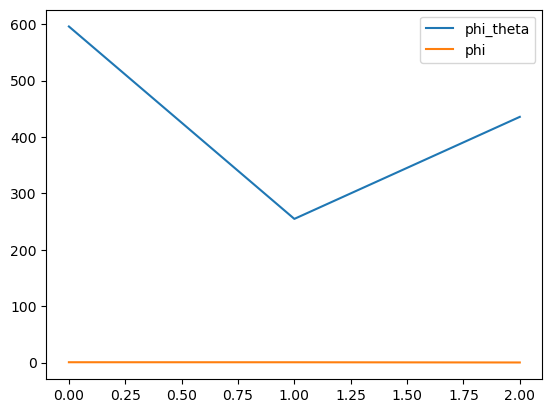

In [66]:
# Plot phi and phi_theta

import matplotlib.pyplot as plt

def plot_phi_theta(phi, theta, N):
    x = np.linspace(0, N-1, N)
    y = [rbm_phi_theta(np.eye(N)[i], theta) for i in range(N)]
    plt.plot(x, y, label="phi_theta")
    y = [phi[i] for i in range(N)]
    plt.plot(x, y, label="phi")
    plt.legend()
    plt.show()

plot_phi_theta(phi, new_theta, N)